# Harringtonine CropArray Example

---

## Notebook summary 


- Load a microscope image of video
- Tracking spots on the image and generate a pandas dataframe with the spots locations
- Creating a croparray with the image and dataframe
- Signal quantification and plotting
- Visualization of croparray with Napari

----

## Importing libraries


----

In [1]:
# To manipulate arrays
import numpy as np 
from skimage.io import imread
import matplotlib.pyplot as plt 
from matplotlib.path import Path
import pylab as pyl
import seaborn as sns; sns.set()  
import pathlib # for working with windows paths
import sys
import cv2
import trackpy as tp
import pandas as pd
#!pip install shapely
from shapely.geometry import Polygon 
from shapely.geometry import Point
current_dir = pathlib.Path().absolute()
croparray_dir = current_dir.parents[0].joinpath('croparray')
sys.path.append(str(croparray_dir))
import crop_array_tools as ca
# %matplotlib inline 
plt.style.use('dark_background')

# Napari 
%gui qt5 
import napari
from napari.utils import nbscreenshot

# Magicgui
from magicgui import magicgui
import datetime
import pathlib

## Functions 

___

In [4]:
def TrackWithMasks(img_max, particle_diameter ,min_m, mask_include, mask_exclude):
    f = tp.batch(img_max, diameter=particle_diameter,minmass=min_m)
    f_list = []
    for i in np.arange(len(f['frame'].unique())):
        f0 = f[f['frame']==i]
        f1 = f0.copy()

        # If no masks, include everything and exclude nothing
        if len(mask_include) == 0 :
            mask_include1 = [[0,0],[0,10000000],[10000000,10000000],[10000000,0]]
        else:
            mask_include1 = mask_include
        if len(mask_exclude) == 0:
            mask_exclude1 = [[0,0],[0,-10],[-10,-10]]
        else:
            mask_exclude1 = mask_exclude

        mask_in = Polygon(mask_include1)  # This is a polygon that defines the mask
        mypts = np.transpose([f1.y,f1.x]) # These are the points detected by trackpy, notice the x/y inversion for napari
        f1['Include']=[mask_in.contains(Point(mypts[i])) for i in np.arange(len(mypts))] # Check if pts are on/in polygon mask  

        # # Label points in nucleus if polygon mask exists
        # if polygon != None:
        mask_out = Polygon(mask_exclude1)  # This is a polygon that defines the mask
        f1['Exclude']=[mask_out.contains(Point(mypts[i])) for i in np.arange(len(mypts))] # Check if pts are on/in polygon mask  
        
        f_list.append(f1[(f1['Include']==True) & (f1['Exclude']==False)])
    f_all = pd.concat(f_list)
    return f_all

## Loading data (and track file, if already available)


----

In [6]:
dir = current_dir.parents[0].joinpath('dataBase','Gabriel_HT_example') 
dir

WindowsPath('c:/Users/tim_s/OneDrive - Colostate/Stasevich Lab/Lab Management/Dry Lab/Python/croparray/dataBase/Gabriel_HT_example')

In [7]:
#Video directory
img_4D_filename = "Max_bactin_Cell04_Good_int8.tif"
img_4D =  imread(os.path.join(dir,img_4D_filename))
img_4D.shape

(60, 2, 512, 512)

In [11]:
# Converting the video to Croparray format
img_croparray = np.expand_dims(img_4D.transpose(0,2,3,1),axis=[0,2]) # 
img_croparray.shape # dimensions MUST be (fov, f , z, y, x, ch)
img_croparray.shape

print("croparray format shape [fov, f , z, y, x, ch] = ", img_croparray.shape)

croparray format shape [fov, f , z, y, x, ch] =  (1, 60, 1, 512, 512, 2)


## Optional tracking: Max projection, masking, and tracking


----

Just view video to determine what are the best z planes

In [75]:
viewer1 = napari.view_image(img_croparray[0,:,:,:,:,1])

Now do max-projection on best-z planes

In [76]:
best_zs = [1,10]
img_max = np.max(img_croparray[0,:,best_zs[0]:best_zs[1],:,:,1],axis=1)
img_max.shape

(65, 512, 512)

Now you can create a mask to exclude regions: Shapes will be excluded and Shapes [1] will be included in tracks

In [79]:
viewer2 = napari.view_image(np.max(img_max,axis=0))  # Max of max, should be a single frame

In [80]:
# Use this if you don't have a mask:
# f_all = TrackWithMasks(img_max,7,1000,[],[])
particle_diameter = 7
min_mass = 1000
viewer3 = napari.view_image(img_max)
f_all = TrackWithMasks(img_max,particle_diameter,min_mass,viewer.layers['Shapes [1]'].data[0][:,-2:],viewer.layers['Shapes'].data[0][:,-2:])
data = f_all[['frame','y','x']].values
layer_name = 'Spots all frames'
viewer3.add_points(data, size = 7, edge_color = 'yellow', symbol='ring', name = layer_name)

Frame 64: 51 features


<Points layer 'Spots all frames' at 0x1dc9a782ca0>

In [91]:
f_all

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,Include,Exclude
0,104.395108,354.094401,3027.407673,1.412496,0.166519,384.717655,37111.0,0.198801,0,True,False
1,150.119950,377.355020,3149.801661,1.422101,0.135695,386.931857,41431.0,0.148198,0,True,False
2,156.698239,423.988493,2610.682933,1.484175,0.189474,302.703205,38783.0,0.175595,0,True,False
3,161.241342,156.650001,4265.996871,1.470740,0.294934,538.723334,45675.0,0.118553,0,True,False
5,164.120414,351.955850,3669.111186,1.448306,0.196036,454.830767,55420.0,0.081238,0,True,False
...,...,...,...,...,...,...,...,...,...,...,...
3973,344.737386,315.874210,6534.586193,1.484772,0.193975,771.152825,57495.0,0.098389,64,True,False
3974,356.948902,221.068131,7565.121893,1.447981,0.104537,927.865351,65606.0,0.077528,64,True,False
3975,359.085184,292.628251,1646.345807,1.523533,0.114400,184.173909,42173.0,0.200098,64,True,False
3976,360.870110,259.869980,4620.491898,1.484192,0.179534,525.468026,57959.0,0.096897,64,True,False


In [81]:
f_all.to_csv(os.path.join(dir,img_4D_filename[:-4]+'.csv'))

Convert f to crop_array format

In [82]:
#only if you didn't track:
spots = f_all.copy() # Nice to copy; seems it can cause to overwrite otherwise
spots['id']=spots.index
spots.rename(columns={'x': 'xc','y': 'yc', 'frame': 'f','signal':'signal_tp'}, 
inplace=True, errors='raise')
spots['fov']=0
spots.rename(columns={'particle':'id'})
spots = spots[['fov','id','f','yc','xc','signal_tp','Include','Exclude']] # keeping signal out of curiousity... want to compare to disk-donut measurements  
spots.head()

,fov,id,f,yc,xc,signal_tp,Include,Exclude
0,0,0,0,104.395108,354.094401,384.717655,True,False
1,0,1,0,150.119950,377.355020,386.931857,True,False
2,0,2,0,156.698239,423.988493,302.703205,True,False
3,0,3,0,161.241342,156.650001,538.723334,True,False
5,0,5,0,164.120414,351.955850,454.830767,True,False


## Create Crop Array
____

Create a crop array from 4D movie

In [83]:
my_ca = ca.create_crop_array(img_croparray,spots,xy_pad=5, dxy=130, dz=500, dt=1, units=['nm','min'], name = os.path.join(dir,img_4D_filename))
my_ca

Original video dimensions:  (1, 65, 13, 512, 512, 3)
Padded video dimensions:  (1, 65, 13, 524, 524, 3)
Max # of spots per frame:  36
Shape of numpy array to hold all crop intensity data:  (1, 36, 65, 13, 11, 11, 3)
Shape of xc and yc numpy arrays:  (1, 36, 65, 3)
Shape of extra my_layers numpy array:  (4, 1, 36, 65)


<xarray.Dataset>
Dimensions:    (fov: 1, n: 36, t: 65, z: 13, y: 11, x: 11, ch: 3)
Coordinates:
  * fov        (fov) int32 0
  * n          (n) int16 0 1 2 3 4 5 6 7 8 9 ... 26 27 28 29 30 31 32 33 34 35
  * t          (t) int32 0 1 2 3 4 5 6 7 8 9 ... 55 56 57 58 59 60 61 62 63 64
  * z          (z) int32 0 500 1000 1500 2000 2500 ... 4000 4500 5000 5500 6000
  * y          (y) int32 -5 -4 -3 -2 -1 0 1 2 3 4 5
  * x          (x) int32 -5 -4 -3 -2 -1 0 1 2 3 4 5
  * ch         (ch) int32 0 1 2
Data variables:
    int        (fov, n, t, z, y, x, ch) int32 672 628 543 772 591 ... 0 0 0 0 0
    xc         (fov, n, t, ch) int32 360 360 360 371 371 371 396 ... 0 0 0 0 0 0
    yc         (fov, n, t, ch) int32 110 110 110 131 131 131 105 ... 0 0 0 0 0 0
    dx         int32 1
    dy         int32 1
    dz         int32 500
    dt         int32 1
    xy_pad     int32 5
    id         (fov, n, t) float64 0.0 67.0 143.0 210.0 ... 0.0 0.0 0.0 0.0
    signal_tp  (fov, n, t) float64 385.0 149.0 540.0 377.0 ... 0.0 0.0 0.0 0.0
    Include    (fov, n, t) float64 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0
    Exclude    (fov, n, t) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    name:     Z:\galindo\1_Imaging_Data\20220210_metabolites\PEP_10mM\Cell04.tif
    date:     video_date

## Save the crop array
____

In [85]:
my_ca.to_netcdf(os.path.join(dir,img_4D_filename[:-4]+'.nc') )

## Quantify signal intensity through time
____

In [86]:
# Measure signals and plot average signal through time, creating 'best_z' layer and 'signal' layer
ca.measure_signal(my_ca, ref_ch=1, disk_r=3, roll_n=3)

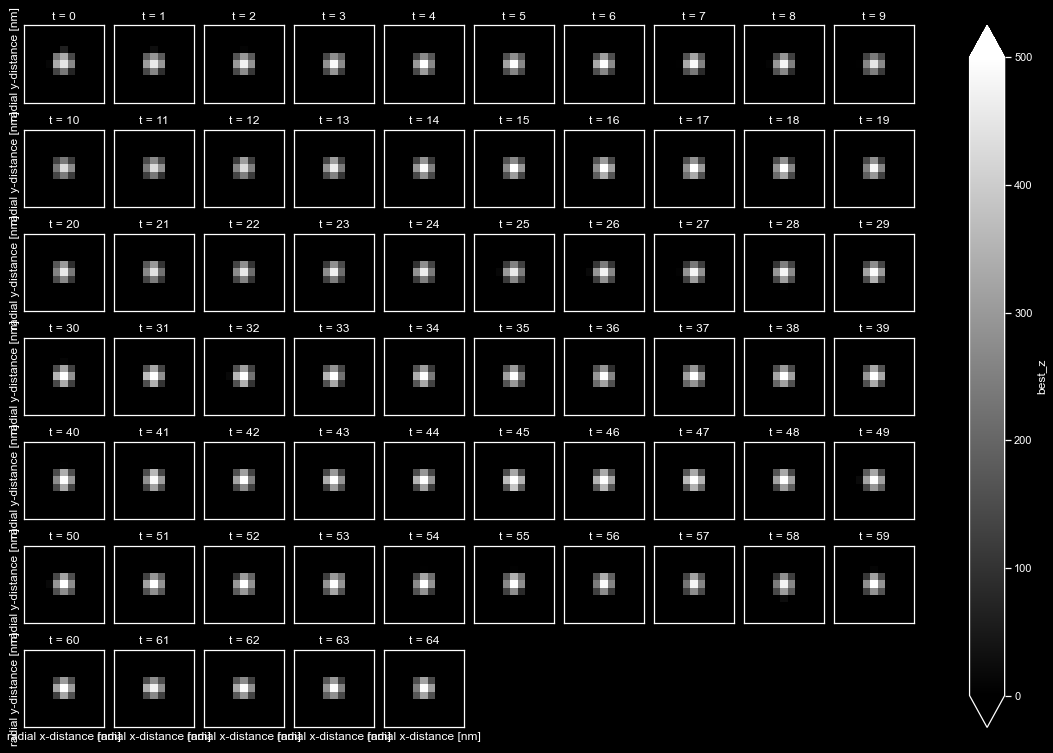

In [87]:
my_ca.best_z.mean('n').sel(fov=0,ch=1).rolling(t=3,min_periods=1).mean().plot.imshow(col='t',col_wrap=10,robust=True,xticks=[],yticks=[],size=1.5,cmap='gray', vmin=0, vmax =500)

Let's compare our disk-donut 'signal' layer (acquired from 3D image) to trackpy's (acquired from max-projection):

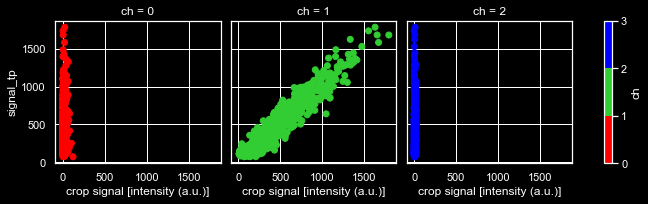

In [88]:
# Let's compare our intensity numbers to those from trackpy:
my_ca.where(my_ca.signal>0).plot.scatter(x='signal',y='signal_tp',col='ch',hue='ch',colors=['red','limegreen','blue'],levels=[0,1,2,3])

Let's look at average signal vs time

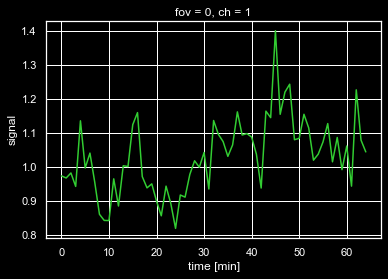

In [89]:
# Let's look at average signal vs time
start_sig = my_ca.signal.mean('n').sel(t=slice(0,4)).mean('t')
end_sig = 0# my_ca.signal.mean('n').sel(t=slice(15,20)).mean('t')
norm_sig = (my_ca.signal.mean('n') - end_sig)/(start_sig - end_sig)
sns.set_palette(['limegreen','limegreen','blue'])
norm_sig.sel(fov=0,ch=1).plot.line(x='t',hue='ch')

Now let's just use trackpy's values:

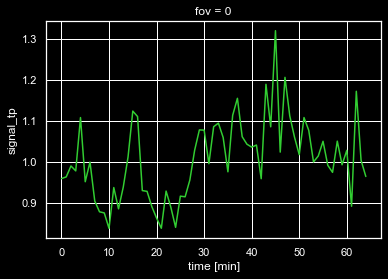

In [90]:
# Let's look at average signal vs time
start_sig = my_ca.signal_tp.mean('n').sel(t=slice(0,4)).mean('t')
end_sig = 0# my_ca.signal_tp.mean('n').sel(t=slice(15,20)).mean('t')
norm_sig = (my_ca.signal_tp.mean('n') - end_sig)/(start_sig - end_sig)
sns.set_palette(['limegreen','limegreen','blue'])
norm_sig.sel(fov=0).plot.line(x='t',hue='ch')

I guess trackpy and the disk donut method do a very good job at getting the intensities of spots. Although note that trackpy got the values from the max-intensity projection. Interesting.

## Visualize crop array montage with Napari
___

Now let's see a montage of the selected spots' best-z planes:

In [96]:
# view the action of montage showing an n x n crop_array through time
viewer = napari.view_image(ca.montage(my_ca.sel(fov=0,ch=0).best_z,row='n',col='t'),contrast_limits=[60,800])

## Optional: Create Track Array
___

In [98]:
f_all

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,In Cell,In Nucleus
0,162.314288,156.047885,1578.220411,1.529673,0.131884,176.624047,28994.0,0.054826,0,True,False
1,182.776411,153.842445,1444.273882,1.508030,0.109588,172.805192,31053.0,0.045938,0,True,False
2,204.002477,370.318794,1458.370542,1.573965,0.036774,147.042052,27266.0,0.065455,0,True,False
3,218.808402,226.898315,1834.273406,1.413531,0.155329,232.748293,34293.0,0.036601,0,True,False
4,231.234459,150.646147,1112.885300,1.781617,0.218430,103.060634,56583.0,0.015261,0,True,True
...,...,...,...,...,...,...,...,...,...,...,...
1576,315.323754,277.645780,2523.266035,1.458111,0.138921,307.396064,33674.0,0.037619,64,True,False
1577,343.883454,266.205445,2563.661782,1.506490,0.109865,284.121134,34931.0,0.034808,64,True,False
1578,349.081788,354.329591,1277.320846,1.534719,0.110253,151.863994,28081.0,0.058718,64,True,False
1579,370.930712,257.361687,1187.420138,1.520906,0.088614,146.685533,28488.0,0.056415,64,True,False


In [99]:
# Note, if you actually wanted to track, you could use the following:
# link tracks
max_distance_movement = 15
track_skip_frames = 3
min_trajectory_length = 10
t = tp.link(f_all, max_distance_movement, memory=track_skip_frames)
t1 = tp.filter_stubs(t, min_trajectory_length)
t1['particle'] = t1['particle']+1 # VERY IMPORTANT NOT TO HAVE TRACK IDs WITH VALUES = 0 WHEN MAKING CROP ARRAYS AS ZERO IS DEFAULT EMPTY VALUE
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique()) 

Frame 64: 20 trajectories present.
Before: 453
After: 30


In [100]:
# only if you tracked:
spots = t1.copy()
spots.rename(columns={'x': 'xc','y': 'yc', 'frame': 'f','signal':'signal_tp','particle':'id'}, 
inplace=True, errors='raise')


spots['fov']=0
spots.rename(columns={'particle':'id'})
spots = spots[['fov','id','f','yc','xc','signal_tp']] # keeping signal out of curiousity... want to compare to disk-donut measurements  
spots.head()

,fov,id,f,yc,xc,signal_tp
frame,,,,,,
0,0,2,0,359.265680,314.304123,141.644791
0,0,13,0,281.979221,213.856341,89.597758
0,0,25,0,247.649565,169.431637,162.030855
0,0,28,0,261.748990,239.128626,110.387506
0,0,29,0,266.199052,202.242530,109.668948


In [101]:
my_ca2 = ca.create_crop_array(img_croparray,spots,xy_pad=particle_diameter//2+1, dxy=130, dz=500, dt=1, units=['nm','min'])

Original video dimensions:  (1, 65, 13, 512, 512, 3)
Padded video dimensions:  (1, 65, 13, 522, 522, 3)
Max # of spots per frame:  13
Shape of numpy array to hold all crop intensity data:  (1, 13, 65, 13, 9, 9, 3)
Shape of xc and yc numpy arrays:  (1, 13, 65, 3)
Shape of extra my_layers numpy array:  (2, 1, 13, 65)


In [102]:
# Measure signals and plot average signal through time, creating 'best_z' layer and 'signal' layer
ca.measure_signal(my_ca2, ref_ch=1, disk_r=3, roll_n=3)

In [103]:
import xarray as xr
import pandas as pd
# Since ids correspond to tracks, we can organize tracks in rows  
my_ids = np.unique(my_ca2.id) # Find all unique ids
my_ids = my_ids[1:] # remove the '0' ID used as filler in Crop Arrays
my_ids
# Get a list of xarrays for each unique id 
my_das = []
for i in np.arange(len(my_ids)):
    temp = my_ca2.groupby('id')[my_ids[i]].reset_index('stacked_fov_n_t').reset_coords('n',drop=True).reset_coords('fov',drop=True).swap_dims({'stacked_fov_n_t':'t'})
    my_das.append(temp)
    del temp
# Concatenate the xarrays together to make a new xarray dataset in a track array format (each track on separate row). Here 'n' is replaced by 'tracks'
my_taz = xr.concat(my_das, dim=pd.Index(my_ids, name='track_id'), fill_value=255) # fill_value=0 so keep int instead of moving to floats with NaNs
my_taz = my_taz.transpose('track_id','fov','n','t','z','y','x','ch', missing_dims='ignore') # reorder for napari
my_taz

<xarray.Dataset>
Dimensions:    (t: 65, z: 13, y: 9, x: 9, ch: 3, track_id: 30)
Coordinates:
  * t          (t) int64 0 1 2 3 4 5 6 7 8 9 ... 55 56 57 58 59 60 61 62 63 64
  * z          (z) int32 0 500 1000 1500 2000 2500 ... 4000 4500 5000 5500 6000
  * y          (y) int32 -4 -3 -2 -1 0 1 2 3 4
  * x          (x) int32 -4 -3 -2 -1 0 1 2 3 4
  * ch         (ch) int64 0 1 2
  * track_id   (track_id) float64 2.0 13.0 25.0 28.0 ... 338.0 353.0 364.0 374.0
Data variables: (12/13)
    int        (track_id, t, z, y, x, ch) int32 686 638 483 690 ... 255 255 255
    xc         (track_id, t, ch) int32 319 319 319 324 324 ... 253 255 255 255
    yc         (track_id, t, ch) int32 364 364 364 374 374 ... 264 255 255 255
    dx         (track_id) int32 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
    dy         (track_id) int32 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
    dz         (track_id) int32 500 500 500 500 500 500 ... 500 500 500 500 500
    ...         ...
    xy_pad     (track_id) int32 4 4 4 4 4 4 4 4 4 4 4 ... 4 4 4 4 4 4 4 4 4 4 4
    id         (track_id, t) float64 2.0 2.0 2.0 2.0 ... 374.0 374.0 374.0 255.0
    signal_tp  (track_id, t) float64 142.0 235.0 236.0 ... 152.0 89.0 255.0
    zc         (track_id, t) int64 5 6 6 6 6 255 6 6 6 ... 255 4 6 7 5 4 6 5 255
    best_z     (track_id, t, y, x, ch) float64 110.1 -336.7 ... 255.0 255.0
    signal     (track_id, t, ch) float64 -25.06 112.4 -21.34 ... 255.0 255.0
Attributes:
    name:     video_filename
    date:     video_date

In [104]:
# view the action of montage showing an n x n crop_array through time
viewer = napari.view_image(ca.montage(my_taz.sel(ch=1).best_z,row='track_id',col='t'),contrast_limits=[60,800])

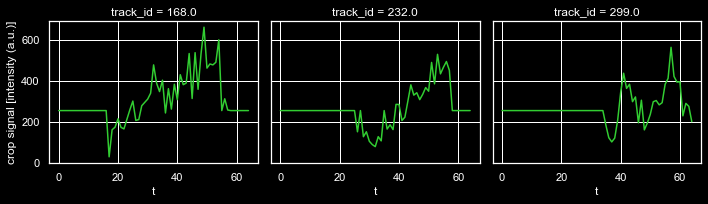

In [105]:
my_taz.isel(track_id=[12,16,20]).sel(ch=1).signal.plot.line(x='t',col='track_id',col_wrap=3)

## Filenames


----

In [15]:
# Data filename and directory
dir = r'X:\Tim'
dir = r'Z:\galindo\1_Imaging_Data\20220210_metabolites\PEP_10mM'
#img_4D_max_filename = r'MAX_Chamber02_HT_Cell01.tif'
img_4D_filename = r'Chamber02_HT_Cell02.tif'
img_4D_filename = r'Cell02.tif'
img_4D_filename = r'Cell04.tif'

# Trying to track in x, y, and z:

Measure signals and plot average signal through time, creating 'best_z' layer and 'signal' layer

In [25]:
max_distance_movement = 5
track_skip_frames = 3
my_frame = 15
min_trajectory_length=2
my_list = []
for my_frame in np.arange(len(img_croparray[0,:])): #np.arange(15,16,1):
    f = tp.batch(img_croparray[0,my_frame,:,:,:,1], diameter=7,minmass=1000)
    t1 = tp.link(f, max_distance_movement, memory=track_skip_frames)
    t = tp.filter_stubs(t1, min_trajectory_length)
    sort_t = t.sort_values(['particle']).groupby('particle').aggregate('max').reset_index().rename(columns={'frame':'z'})
    sort_t['t']=my_frame
    my_list.append(sort_t)
my_df = pd.concat(my_list)
my_df.reset_index()

Frame 12: 6 trajectories present.


NameError: name 'pd' is not defined

In [27]:
import pandas as pd
my_df = pd.concat(my_list)
my_df.reset_index()

,index,particle,y,x,mass,size,ecc,signal,raw_mass,ep,z,t
0,0,1,265.126123,179.288674,1628.551584,1.874931,0.456239,223.443949,57427.0,0.018648,7,0
1,1,3,267.046963,205.697036,1414.572406,1.854444,0.323982,172.348805,57278.0,0.020035,11,0
2,2,7,296.339594,146.190013,1404.200152,1.798229,0.419493,162.043243,54490.0,0.016932,6,0
3,3,8,286.356175,214.849965,1466.282876,1.802885,0.275980,148.216038,57679.0,0.020939,8,0
4,4,9,282.030380,129.168233,1497.468179,1.852901,0.297139,196.285890,55725.0,0.021990,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4588,44,110,308.218702,376.070087,4494.276641,1.868788,0.221681,509.585766,35307.0,0.054544,11,64
4589,45,112,374.020162,257.493160,1620.912914,1.624109,0.148189,192.307055,25918.0,0.062328,10,64
4590,46,118,277.154825,202.980465,1130.622733,1.828707,0.432607,172.092273,38823.0,0.028547,11,64
4591,47,122,232.825651,99.334905,1151.751786,1.730539,0.409167,163.599224,36874.0,0.031245,11,64


In [ ]:
my_df['raw_mass'].hist()

In [ ]:
plt.figure(figsize=(20,10))
tp.annotate(my_df[(my_df['t']==28)&(my_df['raw_mass']<40000)], img_4D_max_real[28]);

In [ ]:
np.array([len(t[t['particle']==i].x) for i in np.arange(len(t.particle))])

In [ ]:
f[f['frame']==6]

# GUI 
___

In [47]:
def my_transpose_list(ar, input_list):
    my_length = len(input_list)  # Should always be 6 = ['fov','f','z','y','x','ch']
    my_none_count = input_list.count('None')  # Get number of 'None' elements in current image
    my_expand_dim_list = tuple(-(np.arange(my_none_count)+1))
    my_count = len(input_list) - my_none_count
    output_list = []
    counter = my_count
    if my_count > 0: 
        for i in np.arange(my_length):
            if input_list[i] == 'None':
                output_list.append(counter)
                counter = counter + 1
            else:
                output_list.append(input_list[i])
    output_ar = np.expand_dims(ar,my_expand_dim_list)
    return np.transpose(output_ar, output_list)
input_list = [0,'None',3,2,'None',1]
my_croparray = my_transpose_list(np.zeros([10,11,12,13]),input_list)
my_croparray.shape

(10, 1, 13, 12, 1, 11)

In [26]:
my_none_count = 3
my_test_array = np.zeros([1,2,3])
my_test_array.shape
np.expand_dims(np.zeros([1,2,3]),my_test_array,axis=(-1,-2,-3)).shape


(1, 2, 3, 1, 1, 1)

In [49]:
from napari.layers import Image, Shapes
from napari.types import LabelsData, ImageData, ShapesData
import napari.types
@magicgui(
    call_button = 'Define Image Dimensions',
    fov_axis = {'choices':['None',0, 1, 2, 3, 4, 5]},
    f_axis = {'choices':['None',0, 1, 2, 3, 4, 5]},
    z_axis = {'choices':['None',0, 1, 2, 3, 4, 5]},
    y_axis = {'choices':['None',0, 1, 2, 3, 4, 5]},
    x_axis = {'choices':['None',0, 1, 2, 3, 4, 5]},
    ch_axis = {'choices':['None',0, 1, 2, 3, 4, 5]},            
)
def define_image_dims(
    image: Image,
    fov_axis: 'None',
    f_axis: 'None',
    z_axis: 'None',
    y_axis: 'None',
    x_axis: 'None',
    ch_axis: 'None',
):
    my_croparray = my_transpose_list(image.data,[fov_axis,f_axis,z_axis,y_axis,x_axis,ch_axis])
    print(my_croparray.shape)

viewer = napari.Viewer()
dw1 = viewer.window.add_dock_widget(define_image_dims, name='Get Video',area='right')

(1, 5, 13, 512, 512, 3)


In [51]:

#viewer.dims.current_step[0] This is how you can access the slider slice in napari

# @magicgui(call_button = 'Load File')
# def open_file(
#     number_of_channels: int,
#     filename = pathlib.Path('/some/path.ext')
# ) -> napari.types.LayerDataTuple:
#     img = imread(filename)
#     my_channel_axis = np.where(np.array(img.shape) == number_of_channels)[0][0]
#     img = np.moveaxis(img_4D,my_channel_axis,0)
#     return [(img[i],{'colormap':'gray','name':'Channel'+str(i)}) for i in np.arange(len(img))]
@magicgui(call_button = 'Make Tracking Channel Layer')
def get_channel(
    image: Image,
    channel_axis: int,
    channel_num: int,
) -> napari.types.LayerDataTuple:
    return (np.expand_dims(np.moveaxis(image.data,channel_axis,0)[channel_num],axis=channel_axis),{'name':image.name+'Ch '+str(channel_num)})

@magicgui(call_button = 'Make Max Projection')
def max_project(
    image1: Image,
    projection_axis: int,
    start_slice: int,
    stop_slice: int,
) -> napari.types.LayerDataTuple:
    return (np.expand_dims(np.max(image1.data, axis=projection_axis),axis=projection_axis),{'name':'Max of '+image1.name})

@magicgui(call_button = 'Detect Spots in Max Projection')
def detect_spots(
    image: Image,
    mask_include: Shapes,
    mask_exclude: Shapes,
    test_frame: int,
    size = 9,
    min_m = 1000,
    detect_spots_in_all_frames = False,
) -> napari.types.LayerDataTuple:
    if detect_spots_in_all_frames:
        f_all = TrackWithMasks(np.squeeze(image.data),size,min_m,mask_include.data[0][:,-2:],mask_exclude.data[0][:,-2:])
        print(f_all)
        print(np.squeeze(image.data).shape)
        data = f_all[['frame','y','x']].values
        data['ch']=1
        layer_name = 'Spots all frames'
    else:
        f = tp.locate(np.squeeze(image.data[test_frame]),diameter=size,minmass=min_m)
        print(f)
        data = f[['y','x']].values
        layer_name = 'Spots frame '+str(test_frame)
    #save_croparray.dir.value = 'test'
    #save_croparray.show()
    return [(data,{'size':size,'edge_color':'yellow','opacity':0.4,'symbol':'ring','name':layer_name}, 'points'),
            (np.max(image,axis=0), {'name': 'Max Projection', 'blending': 'additive'})]

viewer = napari.Viewer()
#viewer = napari.view_image(img_max, name="My Image")
#viewer.window.add_dock_widget(detect_spots)
#viewer.window.add_dock_widget(max_project)
#viewer.window.add_dock_widget(open_file, name='Step 1',area='right')
viewer.window.add_dock_widget(get_channel, name='Get Video',area='right')
dw2 = viewer.window.add_dock_widget(max_project, name='Max Project',area='right')
dw3 = viewer.window.add_dock_widget(detect_spots, name ='Tracking',area='right')
#viewer.window._qt_window.tabifyDockWidget(dw2, dw3)
#viewer.layers.events.changed.connect(detect_spots.reset_choices)